In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


In [2]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [3]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor

In [4]:
train_df = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('/kaggle/input/rossmann-store-sales/store.csv', low_memory=False)
df = train_df.merge(store_df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [5]:
df = add_datepart(df, 'Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 30 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Sales                      1017209 non-null  int64  
 3   Customers                  1017209 non-null  int64  
 4   Open                       1017209 non-null  int64  
 5   Promo                      1017209 non-null  int64  
 6   StateHoliday               1017209 non-null  object 
 7   SchoolHoliday              1017209 non-null  int64  
 8   StoreType                  1017209 non-null  object 
 9   Assortment                 1017209 non-null  object 
 10  CompetitionDistance        1014567 non-null  float64
 11  CompetitionOpenSinceMonth  693861 non-null   float64
 12  CompetitionOpenSinceYear   693861 non-null   float64
 13  Promo2      

In [6]:
dep_var = 'Sales'
df[dep_var] = np.log(df[dep_var] + 1)
procs = [Categorify, FillMissing]

In [7]:
cond = (df.Year < 2014) | (df.Month < 12)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx), list(valid_idx))

In [8]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [9]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
save_pickle('to.pkl', to)
to = load_pickle('to.pkl')
len(to.train.xs), len(to.valid.xs)

(988224, 28985)

In [10]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [11]:
def rmse(pred, y): return round(math.sqrt(((pred-y)**2).mean()),6)
def m_rmse(m, xs, y): return rmse(m.predict(xs), y)

In [12]:
def rf(xs, y, n_estimators=40, max_samples=200_000, 
      max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples,
                                max_features=max_features, min_samples_leaf=min_samples_leaf, 
                                 oob_score=True).fit(xs, y)

In [20]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [14]:
def get_oob(m, df):
    return m.oob_score_

In [15]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [16]:
m = rf(xs, y)

In [17]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.06232, 0.101765)

In [18]:
get_oob(m, xs)

0.9995788386780602

<Axes: ylabel='cols'>

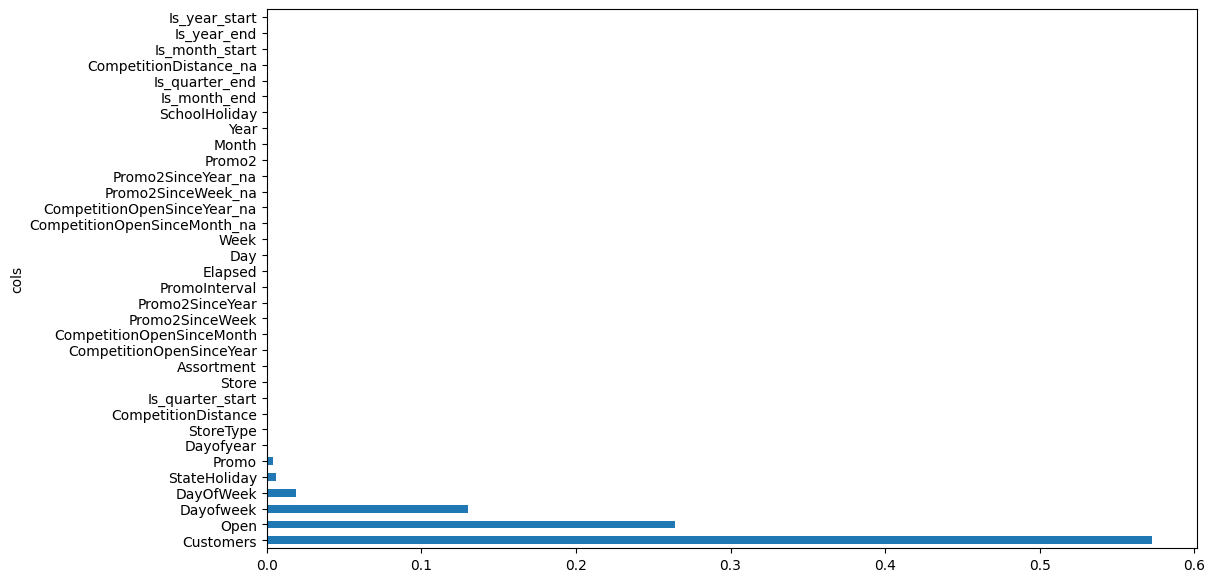

In [21]:
fi = rf_feat_importance(m, xs)
plot_fi(fi)

In [23]:
fi[:10]

,cols,imp
17,Customers,0.572954
18,Open,0.263866
31,Dayofweek,0.129865
16,DayOfWeek,0.019168
0,StateHoliday,0.006108
19,Promo,0.003837
32,Dayofyear,0.001106
1,StoreType,0.000629
21,CompetitionDistance,0.000594
7,Is_quarter_start,0.000540


In [26]:
to_keep = fi[fi.imp > 0.001].cols
len(to_keep)

7

In [27]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

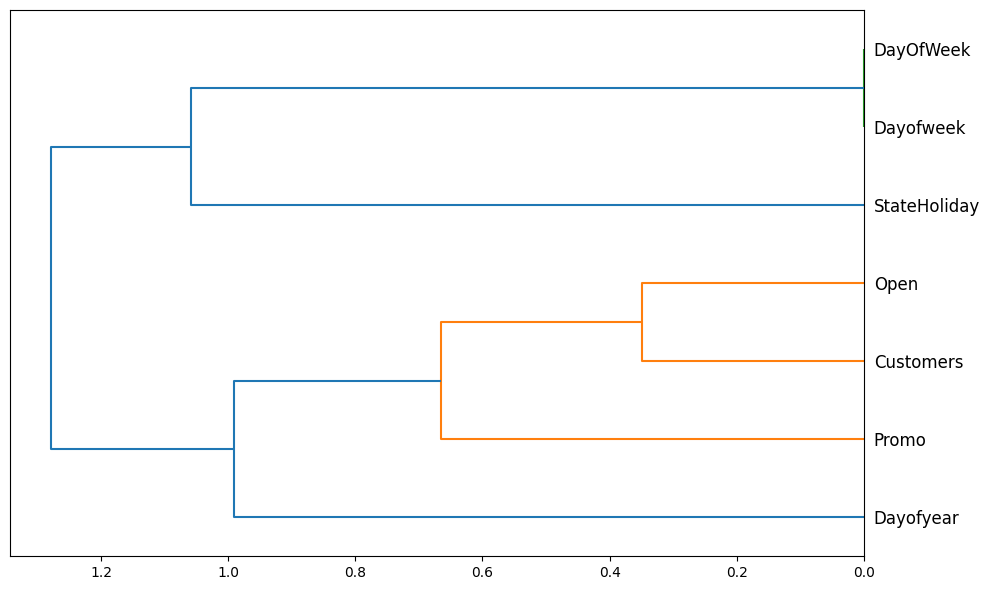

array([[ 2.        ,  3.        ,  0.        ,  2.        ],
       [ 0.        ,  1.        ,  0.3489    ,  2.        ],
       [ 5.        ,  8.        ,  0.6646    ,  3.        ],
       [ 6.        ,  9.        ,  0.99096667,  4.        ],
       [ 4.        ,  7.        ,  1.0588    ,  3.        ],
       [10.        , 11.        ,  1.27909167,  7.        ]])

In [28]:
from scipy.cluster import hierarchy
import numpy as np

def cluster_columns(df, figsize=(10, 6), font_size=12):
    """
    Cluster columns based on correlation and plot a dendrogram
    """
    # Calculate correlation matrix
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hierarchy.distance.squareform(1 - corr)
    z = hierarchy.linkage(corr_condensed, method='average')
    
    # Plot dendrogram
    fig = plt.figure(figsize=figsize)
    dendrogram = hierarchy.dendrogram(z, labels=df.columns, 
                                     orientation='left', 
                                     leaf_font_size=font_size)
    plt.tight_layout()
    plt.show()
    
    return z
cluster_columns(xs_imp)

In [29]:
{c : get_oob(m ,xs_imp.drop(c, axis=1)) for c in ['DayOfWeek', 'Dayofweek', 'Open', 'Customers']}

{'DayOfWeek': 0.9995788386780602,
 'Dayofweek': 0.9995788386780602,
 'Open': 0.9995788386780602,
 'Customers': 0.9995788386780602}

In [30]:
to_drop = ['DayOfWeek']
get_oob(m, xs_imp.drop(to_drop, axis=1))

0.9995788386780602

In [32]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [33]:
save_pickle('xs_final.pkl', xs_final)
save_pickle('valid_xs_final.pkl', valid_xs_final)
xs_final = load_pickle('xs_final.pkl')
valid_xs_final = load_pickle('valid_xs_final.pkl')

In [37]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.168485, 0.171895)

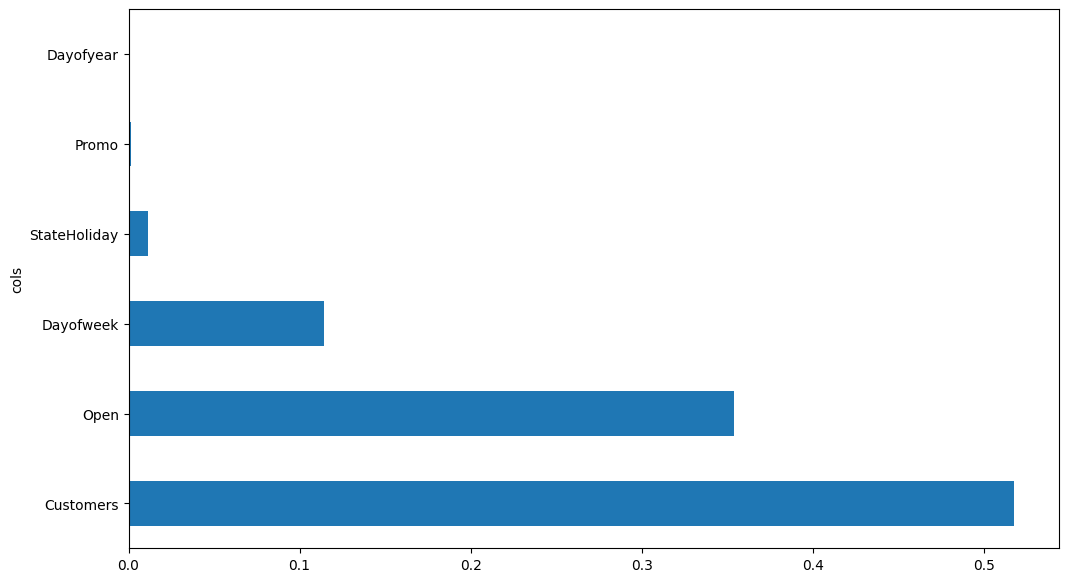

In [39]:
plot_fi(rf_feat_importance(m, xs_final));

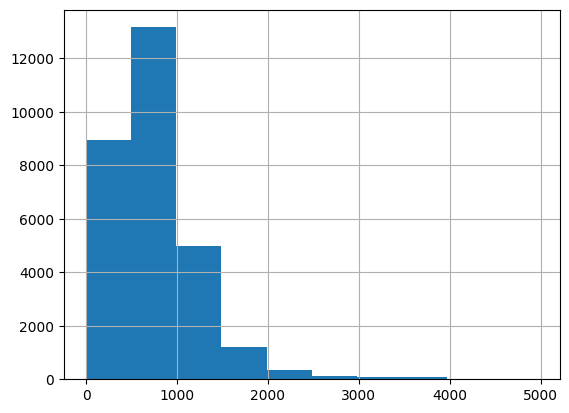

In [40]:
ax = valid_xs_final['Customers'].hist()
plt.show()

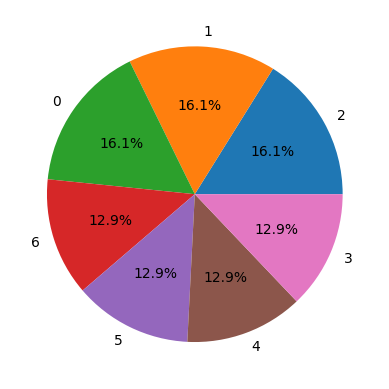

In [48]:
valid_xs_final['Dayofweek'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.show()

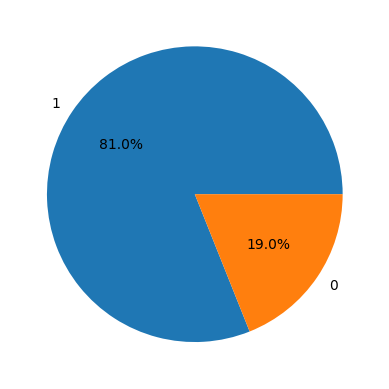

In [43]:
valid_xs_final['Open'].value_counts().plot.pie(autopct='%1.1f%%')
plt.ylabel('')
plt.show()

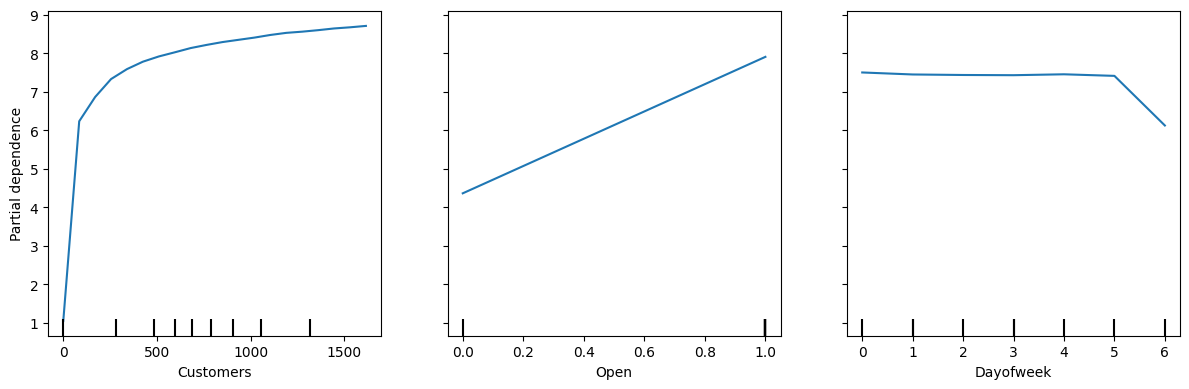

In [49]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(12,4))
PartialDependenceDisplay.from_estimator(m, valid_xs_final, ['Customers', 'Open', 'Dayofweek'],
                                       grid_resolution=20, ax=ax)
plt.tight_layout()
plt.show()

In [50]:
!pip install treeinterpreter waterfallcharts

  Preparing metadata (setup.py) ... done
  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3388 sha256=5e38a89f2e296beb572f2a7a980d998d8f61d6da9ff11428ef57f8be11b636c3
  Stored in directory: /root/.cache/pip/wheels/49/9a/ff/ec03fce8e52feb9578e6d919014384cd15a7f1a2d90f56fce9
Successfully built waterfallcharts


In [52]:
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall 

In [55]:
row = valid_xs_final.iloc[:10]
prediction, bias, contribution = treeinterpreter.predict(m, row.values)

In [57]:
prediction[0], bias[0], contribution[0].sum()

(array([8.07704458]), 7.27180212299648, 0.805242461545246)

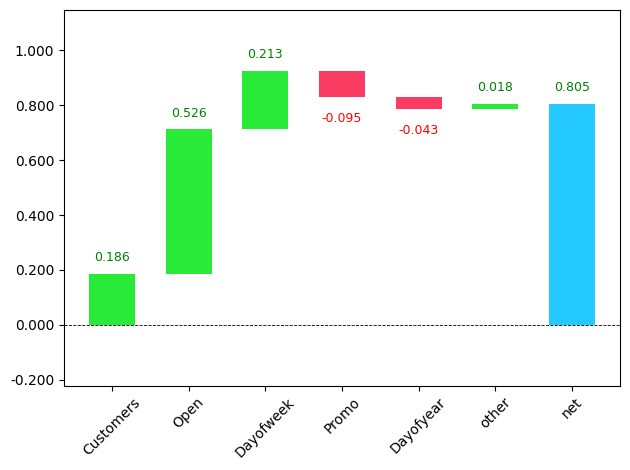

In [59]:
waterfall(valid_xs_final.columns, contribution[0], threshold=0.08, 
         rotation_value=45, formatting='{:,.3f}');

In [61]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))
for c in ('Promo', 'Dayofyear'):
    m = rf(xs_final.drop(c, axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c, axis=1), valid_y))

orig 0.173098
Promo 0.172729
Dayofyear 0.208848


In [62]:
var = ['Promo']
xs_final_time = xs_final.drop(var, axis=1)
valid_xs_final_time = valid_xs_final.drop(var, axis=1)

m= rf(xs_final_time, y)
m_rmse(m, valid_xs_final_time, valid_y)

0.173075